# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/

/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face


In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 49.5 MB 96.8 MB/s 
     |████████████████████████████████| 1.0 MB 57.0 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 8.4 MB/s 


In [5]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel
from os.path import exists

In [6]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


## 1) Preconditions
First we need a dataset of human faces.

In [7]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    print('Downloading dataset')
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

Here are few examples of generated data.


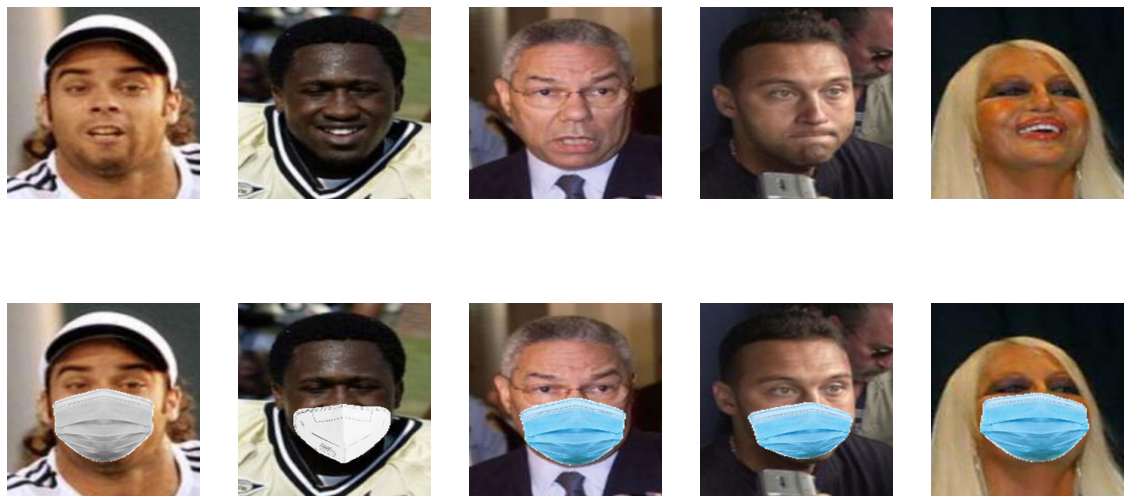

In [8]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

# train_folder = configuration.get('train_data_path')
# test_folder = configuration.get('test_data_path')

# # if os.path.exists(train_folder) and os.path.exists(test_folder):
# #     print('Testing and training data already generated')
# # else:
# dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 5
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')

## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [9]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 20
batch_size = 12

In [10]:
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

model.compute_output_shape(input_shape=(None, 256,256,3))
model.save("./mask2face_siva_trained")

# If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('path_to_your_trained_model.h5')

Using UNet Resnet model
Loading training data from data/train with limit of 10000 images
Loading testing data from data/test with limit of 1000 images
9/9 [==============================] - 43s 3s/step - loss: 0.6339 - acc: 0.2474 - recall: 0.7573 - precision: 0.9882
- TEST -> LOSS:     0.6339, ACC:     0.2474, RECALL:     0.7573, PRECISION:     0.9882
Epoch 1/20
299/299 [==============================] - 2992s 3s/step - loss: 0.2400 - acc: 0.7983 - recall: 0.5218 - precision: 1.0000 - val_loss: 0.1725 - val_acc: 0.8224 - val_recall: 0.4495 - val_precision: 0.9998
Epoch 2/20
299/299 [==============================] - 282s 817ms/step - loss: 0.1384 - acc: 0.8361 - recall: 0.3954 - precision: 1.0000 - val_loss: 0.1303 - val_acc: 0.8965 - val_recall: 0.4344 - val_precision: 0.9998
Epoch 3/20
299/299 [==============================] - 282s 817ms/step - loss: 0.1032 - acc: 0.8925 - recall: 0.3746 - precision: 1.0000 - val_loss: 0.0995 - val_acc: 0.9131 - val_recall: 0.3794 - val_precision: 

INFO:tensorflow:Assets written to: ./mask2face_siva_trained/assets


INFO:tensorflow:Assets written to: ./mask2face_siva_trained/assets


## 4) Results
Our model is trained, and we can look at it's performance

(256, 256)
(253, 256)
(256, 256)
Outputs generated on previously unseen data.


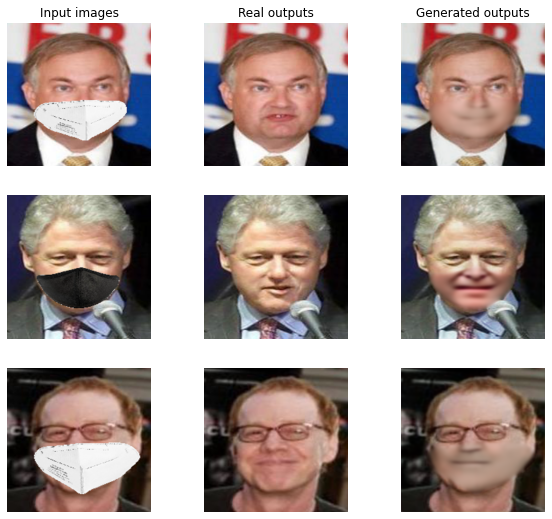

In [11]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

In [12]:
model.compute_output_shape(input_shape=(None, 256,256,3))
model.save("./mask2face_siva_trained")

INFO:tensorflow:Assets written to: ./mask2face_siva_trained/assets


INFO:tensorflow:Assets written to: ./mask2face_siva_trained/assets
